## Clipping data

emsarray provides utilities to clip data to some arbitrary geographic area. Any supported file format can be clipped using an identical API.

In [1]:
import emsarray
import shapely.geometry
import tempfile

Set up the environment...

In [2]:
# This makes the figures nice and big for this notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# The coastlines used in the maps have some bad polygons,
# which causes some warnings. Lets turn those off.
import shapefile
shapefile.VERBOSE = False


To demonstrate the data slicing, we need a custom plot function. Refer to the clip.ipynb notebook for further information about plotting.

In [3]:
import numpy as np
from emsarray.plot import bounds_to_extent
from matplotlib import patches, pyplot, collections

def plot_clipped_on_grid(original, clipped, variable, clip_geometry):
    """Plot a variable from a clipped dataset
    on top of the grid of the entire dataset,
    plus the clip polygon
    """
    figure = pyplot.figure()
    clipped.ems.plot_on_figure(figure, variable)
    axes = figure.axes[0]

    grid_cells = original.ems.make_patch_collection(
        edgecolor='grey', linewidth=0.5, facecolor='none', alpha=0.5, zorder=0)
    axes.add_collection(grid_cells)

    clip_patch = patches.Polygon(
        clip_geometry.exterior.coords, edgecolor="red", fill=False, linewidth=2, zorder=10)
    axes.add_patch(clip_patch)
    
    axes.set_extent(bounds_to_extent(clip_geometry.envelope.buffer(0.2).bounds))

First, open a dataset and define a clip region. A clip region can be any Shapely geometry. Typically this will be a polygon, but you can also use points, lines, multipolygons, and any other shape.
Lets use the GBR4 dataset for this example.

In [4]:

gbr4 = emsarray.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_2.0.ncml?zc[0:1:46],longitude[0:1:179][0:1:599],latitude[0:1:179][0:1:599],botz[0:1:179][0:1:599],time[0:1:10],temp[0:1:10][0:1:46][0:1:179][0:1:599]")
whitsundays_clip = shapely.geometry.Polygon([
    (147.391621, -20.346789), 
    (149.892177, -23.045809),
    (153.440517, -20.680525),
    (151.430263, -18.277805),
    (147.391621, -20.346789),
])


The dataset can be clipped to this region using dataset.ems.clip(...).

This operation needs a temporary directory to save intermediate files in to. We use tempfile.TemporaryDirectory() to manage this for us.

Before the temporary directory is cleaned up we need to do one of two things. For small datasets or small clip regions we can call dataset.load() to load the entire clipped dataset in to memory. For larger datasets or clip regions that don't fit in to memory, we need to save dataset to a new file using dataset.to_netcdf().

In [5]:
with tempfile.TemporaryDirectory() as temp_name:
    whitsundays = gbr4.ems.clip(whitsundays_clip, temp_name)
    whitsundays.load()

We can now plot this clipped dataset using th plot_clipped_on_grid() function we defined earlier. The coloured data regions come from the clipped dataset, while the grid lines are taken from the original dataset, to demonstrate what was removed.

Any cell that intersects the clip region is selected. All neighbouring cells of these selected cells are added to the selected set, to form a buffer. Every other cell is masked with nan, and the dataset extents trimmed to the minimum bounding region of the clip polygon.

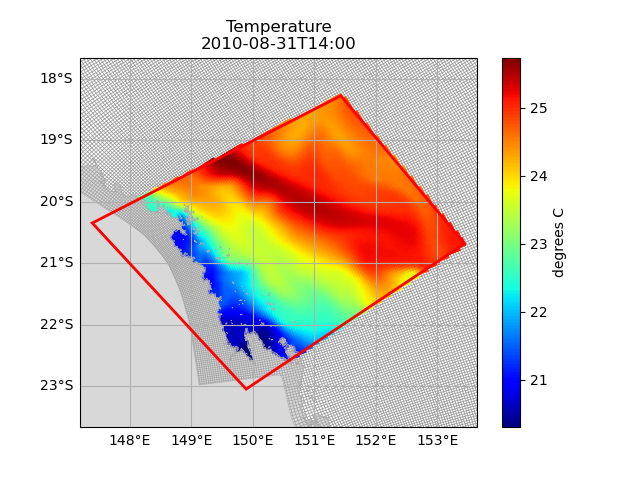

In [7]:
%matplotlib ipympl
plot_clipped_on_grid(gbr4, whitsundays.isel(time=0, k=-1), "temp", whitsundays_clip)